# Pima Indians Diabetes 

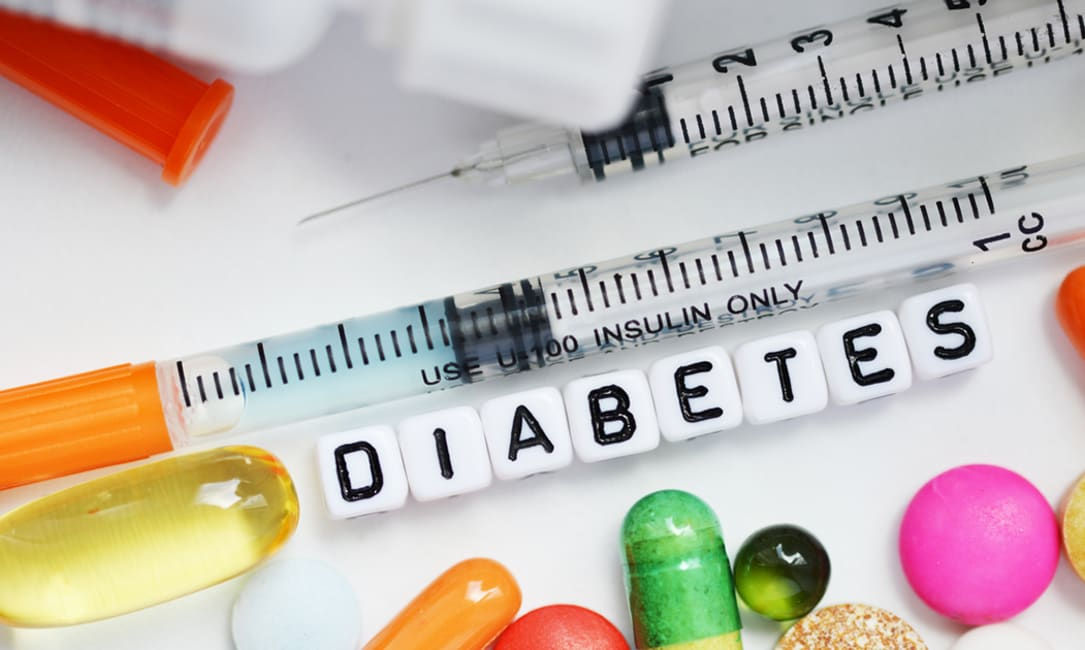

<font color = '#F0C243'>
Content:
    
1. [Load and check data](#1)
1. [Analysis of variables](#2)
1. [Sampling](#3)    
1. [Missing Value](#4)     
1. [Outlier Detection](#5)
    *           [Isolation Forest](#6)
    *           [Interquartile Range(IQR)](#7)
1. [Feature Selection](#8) 
1. [Normalization](#9)
1. [Models](#30)    
    *           [CatBoost Classifier](#10)
    *           [XGBoost Classifier](#11)
    *           [Random Forest](#12) 
    *           [Decision Tree](#13)
    *           [KNN](#14)
    *           [Logistic Regression](#15)
    *           [Support Vector Classifier](#16)
1. [Comparisons](#17)
    

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id = "1"></a><br>
# Load and Check Data

In [ ]:
data=pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')

In [ ]:
data.head()

In [ ]:
data.describe()

## When we compare the minimum and maximum values with the average, it is understood that we have some outliers. Let's see them in boxplot.

In [ ]:
data1=data.drop('Outcome',axis=1)
data1.plot(kind='box', subplots=True, layout=(4,4), sharex=False,sharey=False ,figsize =(15,15))
plt.show()


<a id = "2"></a><br>
# Analysis of variables

In [ ]:
def bar_plot(variable):
    var =data[variable]
    varValue = var.value_counts()
    plt.figure(figsize=(15,7))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    
    plt.show()
    print("{}: \n {}".format(variable,varValue))

In [ ]:
data.columns

In [ ]:
category1 = ['Pregnancies','Age']
    
for c in category1:
    bar_plot(c)

## Let's look at the distribution of variables according to the target.

In [ ]:
from matplotlib import pyplot
a4_dims = (18, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(x='Age',hue='Outcome',data=data, linewidth=1,ax=ax)

In [ ]:
a4_dims = (18, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.countplot(x='Pregnancies',hue='Outcome',data=data, linewidth=1,ax=ax)

In [ ]:
colors = {0:'#cd1076', 1:'#008080'}
fig, ax = plt.subplots()
grouped = data.groupby('Outcome')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter'
               ,x='Glucose', y='Age', label=key
               ,color=colors[key])
plt.show()

In [ ]:
colors = {0:'#cd1076', 1:'#008080'}
fig, ax = plt.subplots()
grouped = data.groupby('Outcome')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter'
               ,x='BMI', y='Age', label=key
               ,color=colors[key])
plt.show()

<a id = "3"></a><br>
# And the distribution of our target column

In [ ]:
data['Outcome'].value_counts().plot(kind='pie',colors=['#2C4373', '#F2A74B'],autopct='%1.1f%%',figsize=(9,9))
plt.show
varValue = data.Outcome.value_counts()
print(varValue)

## Our dataset does not seem too balance. Let's balance it with Upsampling method

In [ ]:
from sklearn.utils import resample
df_majority = data.loc[data.Outcome == 0].copy()
df_minority = data.loc[data.Outcome == 1].copy()
df_minority_upsampled = resample(df_minority,
                             replace=True,  # sample with replacement
                            n_samples=500,  # to match majority class
                            random_state=123) 
data = pd.concat([df_majority, df_minority_upsampled])

# Current Version:

In [ ]:
data['Outcome'].value_counts().plot(kind='pie',colors=['#F2A74B', '#cd919e'],autopct='%1.1f%%',figsize=(9,9))
plt.show
varValue = data.Outcome.value_counts()
print(varValue)

<a id = "4"></a><br>
# Missing Value

In [ ]:
data.isnull().sum()


## No missing value.

<a id = "5"></a><br>
# Outlier Detection
* Isolation Forest
* Interquartile Range (IQR)

<a id = "6"></a><br>
# Isolation Forest
## -1= Number of Outliers

In [ ]:
from sklearn.ensemble import IsolationForest
from collections import Counter
rs=np.random.RandomState(0)
clf = IsolationForest(max_samples=100,random_state=rs, contamination=.1) 
clf.fit(data)
y_pred_train = clf.predict(data)
sayı = Counter(y_pred_train)
print(sayı)

<a id = "7"></a><br>
# Interquartile Range (IQR)

In [ ]:
from collections import Counter
def detect_outliers(data,features):
    outlier_indices = []
    for c in features:
        # 1st quartile
        Q1 = np.percentile(data[c],25)
        # 3rd quartile
        Q3 = np.percentile(data[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = data[(data[c] < Q1 - outlier_step) | (data[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [ ]:
data.loc[detect_outliers(data,['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])]

# We drop the rows with outliers.

In [ ]:
data = data.drop([298,349,78,261,193,706,125,177,579,220,715,655,584,618,661,659,45,243], axis=0)


<a id = "8"></a><br>
# Feature Selection

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


data["Outcome"] = data.Outcome
X = data.drop("Outcome",1)
y = data["Outcome"]
data.head()
plt.figure(figsize=(15,7))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(cor["Outcome"]) #absolute value
#High Correlations
relevant_features = cor_target[cor_target>=0.2]
relevant_features

In [ ]:
newdata=data.drop(['BloodPressure', 'SkinThickness', 'Insulin','DiabetesPedigreeFunction'],axis=1)

In [ ]:
newdata.head()

In [ ]:
data=pd.DataFrame(newdata)

<a id = "9"></a><br>
# Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
X = data.iloc[:, 0:4]
Y = data.iloc[:, 4]
nd = StandardScaler()
nd.fit(X)
X =nd.transform(X)
print(Y)

<a id = "30"></a><br>
# Models

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn import model_selection
                  
X = data.iloc[:, 0:4]
Y = data.iloc[:, 4]
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2, random_state = 100)

#to plot a graph
accuracies ={} 
means={}
randoms={}


<a id = "10"></a><br>
# CatBoost Classifier
### CatBoost is a machine learning algorithm that uses gradient boosting on decision trees.
1. RandomCV
1. Cross Validation

### RandomizedSearchCV

In [ ]:
from catboost import CatBoostClassifier
cparams = {'depth':range(1,15),
          'iterations':[100],
          'learning_rate':[0.03,0.001,0.1], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,50,100,200],
          
          }
model = CatBoostClassifier()
c_randomcv_model=RandomizedSearchCV(estimator=model,param_distributions=cparams, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)

In [ ]:
print('Catboost_randomcv_model accuracy = {}'.format(c_randomcv_model.best_score_))
random=c_randomcv_model.best_score_*100
randoms['Catboost']=random

### Cross Validation

In [ ]:
kfold=model_selection.KFold(n_splits=5)
modelL=CatBoostClassifier(learning_rate=0.03,l2_leaf_reg=3,iterations=100,depth=12,border_count=32)
results=model_selection.cross_val_score(modelL,X,Y,cv=kfold)


In [ ]:
print(results)
print(results.mean()*100)
mean=results.mean()*100
means['Catboost']=mean

<a id = "11"></a><br>
# XGBOOST Classifier
1. Manual Tuning
1. Randomized Search CV
1. Grid Search CV
1. Cross Validation

### Manual Tuning

In [ ]:
from xgboost import XGBClassifier
accuracy = []
for n in range(1,11):
    xgb =XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.78,
                           colsample_bytree=1, max_depth=n)
    xgb.fit(X_train,y_train)
    prediction = xgb.predict(X_test)
    accuracy.append(accuracy_score(y_test, prediction))
print(accuracy)    
plt.plot(range(1,11), accuracy,color='#cd5555')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.show()    

### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb_params = {
    'learning_rate' : [0.08, 0.06, 0.04, 0.09],      
    'max_depth': range(1,40),
    'n_estimators': [100, 200, 300,500,1000]}
xgb =XGBClassifier()
xgb_randomcv_model=RandomizedSearchCV(estimator=xgb, param_distributions=xgb_params, n_iter=2, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(xgb_randomcv_model.best_params_)
print('xgb_randomcv_model accuracy = {}'.format(xgb_randomcv_model.best_score_))
random=xgb_randomcv_model.best_score_*100
randoms['XGBoost']=random

### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
xgb_params = { 'learning_rate' : [0.08, 0.06, 0.04, 0.09],      
    'max_depth': range(1,40),
    'n_estimators': [100, 200, 300,500,1000]}
xgb =XGBClassifier()
xgb_gridcv_model = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(xgb_gridcv_model.best_params_)
print('rf gridcv model accuracy score = {}'.format(xgb_gridcv_model.best_score_))
acc=xgb_gridcv_model.best_score_ *100
accuracies[' XGBoost Gridsearch']=acc


### Cross Validation

In [ ]:
kfold=model_selection.KFold(n_splits=5)
modelL=XGBClassifier(n_estimators=100, max_depth=11,learning_rate=0.09)
results=model_selection.cross_val_score(modelL,X,Y,cv=kfold)
print(results)
print(results.mean()*100)
mean=results.mean()*100
means['XGBoost']=mean

<a id = "12"></a><br>
# Random Forest 

### RandomizedSearchCV
1. Randomized Search CV
1. Cross Validation

### RandomizedSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_params = {
   'max_depth': range(1,40),
    'max_features': range(1,40),
    'min_samples_leaf': range(1,20),
    'min_samples_split': range(1,20),
    'n_estimators': [100, 200, 300,500,1000]}
rf=RandomForestClassifier()
rf_randomcv_model=RandomizedSearchCV(estimator=rf, param_distributions=rf_params, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(rf_randomcv_model.best_params_)
print('rf_randomcv_model accuracy score = {}'.format(rf_randomcv_model.best_score_))
random=rf_randomcv_model.best_score_*100
randoms['Random Forest']=random

### Cross Validation

In [ ]:
kfold=model_selection.KFold(n_splits=5)
modelL=RandomForestClassifier(n_estimators=100,min_samples_split=14, min_samples_leaf=4,max_depth=7)
results=model_selection.cross_val_score(modelL,X,Y,cv=kfold)
print(results)
print(results.mean()*100)
mean=results.mean()*100
means['Random Forest']=mean

<a id = "13"></a><br>
# Decision Tree
1. Randomized Search CV
1. Cross Validation

### RandomizedSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_params = {'min_weight_fraction_leaf' : [0.0 , 0.2 , 0.4 , 0.6 ,0.8],
   'max_depth': range(1,40),
    'max_features': range(1,40),
    'min_samples_leaf': range(1,40),
    'max_leaf_nodes' : range(1,40)
    
    }
dt=DecisionTreeClassifier()
dt_randomcv_model=RandomizedSearchCV(estimator=dt, param_distributions=dt_params, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(dt_randomcv_model.best_params_)
print('rf_randomcv_model accuracy score = {}'.format(dt_randomcv_model.best_score_))
random=dt_randomcv_model.best_score_*100
randoms['Decision Tree']=random

### Cross Validation

In [ ]:
kfold=model_selection.KFold(n_splits=5)
modelL=DecisionTreeClassifier(min_weight_fraction_leaf=0.0,max_features=3, min_samples_leaf=15,max_depth=7,max_leaf_nodes=28)
results=model_selection.cross_val_score(modelL,X,Y,cv=kfold)
print(results)
print(results.mean()*100)
mean=results.mean()*100
means['Decision Tree']=mean

<a id = "14"></a><br>
# KNN
1. RandomizedSearch CV
1. GridSearch CV
1. Cross Validation

### RandomizedSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_params = {'n_neighbors' : range(1,10)
   }
knn=KNeighborsClassifier()
knn_randomcv_model=RandomizedSearchCV(estimator=knn, param_distributions=knn_params, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(knn_randomcv_model.best_params_)
print('rf_randomcv_model accuracy score = {}'.format(knn_randomcv_model.best_score_))
random=knn_randomcv_model.best_score_*100
randoms['KNN']=random

### GridSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_params = {'n_neighbors' : range(1,10),
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto','ball_tree','kd_tree','brute'],
              'p' : [1,2]
   }
knn=KNeighborsClassifier()
knn_gridcv_model=GridSearchCV(estimator=knn, param_grid=knn_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(knn_gridcv_model.best_params_)
print('rf_randomcv_model accuracy score = {}'.format(knn_gridcv_model.best_score_)) 
acc=knn_gridcv_model.best_score_ *100
accuracies['KNN Gridsearch']=acc


### Cross Validation

In [ ]:
kfold=model_selection.KFold(n_splits=5)
modelL=KNeighborsClassifier(n_neighbors= 1)
results=model_selection.cross_val_score(modelL,X,Y,cv=kfold)
print(results)
print(results.mean()*100)
mean=results.mean()*100
means['KNN']=mean

<a id = "15"></a><br>
# Logistic Regression
1. Grid Search CV
1. Cross Validation

### GridSearchCV

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_params = {'penalty' : ['l1','l2', 'elasticnet','none'],
              'C' : range(1,7),
            'solver' :['newton-cg','lbfgs','liblinear','sag','saga'],
             'max_iter' : [100,200],
             'multi_class' : ['ovr','multinomial']
   }
lr=LogisticRegression()
lr_gridcv_model=GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(lr_gridcv_model.best_params_)
print('rf_gridcv_model accuracy score = {}'.format(lr_gridcv_model.best_score_)) 
random=lr_gridcv_model.best_score_*100
randoms['Logistic Regression']=random

### Cross Validation

In [ ]:
kfold=model_selection.KFold(n_splits=5)
model=LogisticRegression(C=2,max_iter=100,multi_class='ovr',penalty='l2',solver='liblinear')
results=model_selection.cross_val_score(model,X,Y,cv=kfold)
print(results)
print(results.mean()*100)
mean=results.mean()*100
means['Logistic Regression']=mean

<a id = "16"></a><br>
# Support Vector Classifier
1. Grid Search CV
1. Cross Validation

### Gridsearch CV

In [ ]:
from sklearn.svm import SVC
svc_params= {'C' : [0.1,0.2,0.3,0.001,0.003],
             'kernel': ['linear','poly','rbf','sigmoid']}
svc=SVC()
svc_gridcv_model=GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=2).fit(X_train,y_train)
print(svc_gridcv_model.best_params_)
print('rf_gridcv_model accuracy score = {}'.format(svc_gridcv_model.best_score_)) 
acc=svc_gridcv_model.best_score_ *100
accuracies['SVC Gridsearch']=acc

### Cross Validation

In [ ]:
kfold=model_selection.KFold(n_splits=5)
model=SVC(C=0.1,kernel='linear')
results=model_selection.cross_val_score(model,X,Y,cv=kfold)
print(results)
print(results.mean()*100)
mean=results.mean()*100
means['SVC']=mean

<a id = "17"></a><br>
# Comparisons

## GridSearch CV

In [ ]:
colors = ["#C06C84", "#5E1742", "#005D8E"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,101,5))
plt.ylabel("GridSearch Scores%")
plt.xlabel("\n\n Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

## RandomSearch CV

In [ ]:
colors = ["#00008b", "#00e5ee", "#cd1076", "#008080","#cd5555",'black']

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,101,5))
plt.ylabel("Random Search Scores %")
plt.xlabel("\n\n Algorithms")
sns.barplot(x=list(randoms.keys()), y=list(randoms.values()), palette=colors)
plt.show()

## Cross Validation

In [ ]:
colors = ["#C06C84", "#5E1742", "#005D8E", "#00ADB5","#3E606F","#EFAB1F"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,101,5))
plt.ylabel("Cross Validation Scores %")
plt.xlabel("\n\n Algorithms")
sns.barplot(x=list(means.keys()), y=list(means.values()), palette=colors)
plt.show()


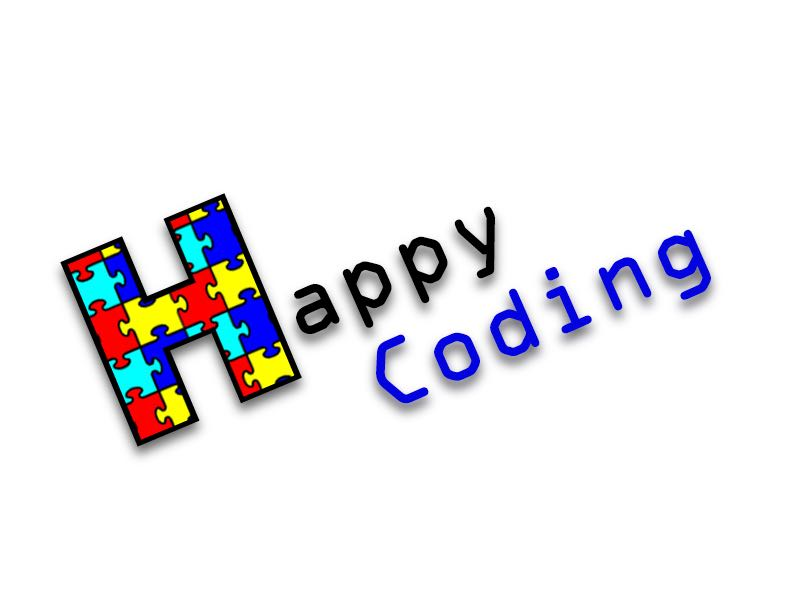